In [22]:
import mlflow
import mlflow.tensorflow
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
from tensorflow.keras.callbacks import ModelCheckpoint
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

from SpectraVAE import SpectraVAE
from BandPassVAE import BandPassVAE
from ParamVAE import ParamVAE
from ParamVAEapply import ParamVAEapply
from validate_HSC import validate_HSC


fig_path = "/data/kirg/MMVAE/MLFlow"
weight_path = "/data/kirg/MMVAE/bpz_tmpl_1.1"
os.makedirs(weight_path, exist_ok=True)

In [23]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23512678400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4685719041941050656
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



I0000 00:00:1756661003.614838  253705 gpu_device.cc:2019] Created device /device:GPU:0 with 22423 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [24]:
'''
mlflow.set_tracking_uri("file:/data/kirg/MMVAE/MLFlow/mlruns")

mlflow.set_experiment("mmvae_bpztmpl")

mlflow.start_run(nested=True)

beta = 3e-3
epochs = 50
latent_dim = 32
batch_size = 512
n_param = 1
save_train = True
tbl_train_name = 'train_dataset_bpz_tmpl.fits'
tbl_path = '/data/kirg/MMVAE/datasets'

mlflow.log_param("beta", beta)
mlflow.log_param("epochs", epochs)
mlflow.log_param("latent_dim", latent_dim)
'''

beta = [1e-5, 3e-4, 3e-5]
epochs = 100
latent_dim = 64
batch_size = 64
n_param = 4
save_train = True
tbl_train_name = 'train_dataset_cigale_tmpl.fits'
tbl_path = '/data/kirg/MMVAE/datasets'




In [25]:
'''
from gen_dataset import *
from filters import filter_data, filters

filer_names = [name for name, _ in filters]

reader = SpectrumReader('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
lages, lmets, flx, wl = reader.read()

# Setup interpolator and processor
interpolator = SpectrumInterpolator(lages, lmets, flx)
processor = SpectrumProcessor(interpolator)

# Setup photometric calculator with filters
photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)
                
# Create DatasetBuilder with processor, wavelength grid and photocalc
builder = DatasetBuilder(processor, wl, photocalc)

# Generate dataset (already includes photometry and augmentation)
integrals, params, spectra = builder.generate(n_samples=32000, age_range=(10, 15000),
                                              young_age_range=(10, 3000),
                                              young_age_threshold=4000,
                                              old_blend_prob=0.0,
                                              young_extinction_prob=0.0, 
                                              eml_prob=0.0, 
                                              n_processes=8)

''' 

"\nfrom gen_dataset import *\nfrom filters import filter_data, filters\n\nfiler_names = [name for name, _ in filters]\n\nreader = SpectrumReader('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')\nlages, lmets, flx, wl = reader.read()\n\n# Setup interpolator and processor\ninterpolator = SpectrumInterpolator(lages, lmets, flx)\nprocessor = SpectrumProcessor(interpolator)\n\n# Setup photometric calculator with filters\nphotocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)\n\n# Create DatasetBuilder with processor, wavelength grid and photocalc\nbuilder = DatasetBuilder(processor, wl, photocalc)\n\n# Generate dataset (already includes photometry and augmentation)\nintegrals, params, spectra = builder.generate(n_samples=32000, age_range=(10, 15000),\n                                              young_age_range=(10, 3000),\n                                              young_age_threshold=4000,\n                                              o

In [26]:
'''
from astropy.table import Table
from gen_dataset import *
import glob
from filters import filter_data, filters
import matplotlib.pyplot as plt
import numpy as np

filer_names = [name for name, _ in filters]

list_sed_templ = glob.glob('/data/kirg/MMVAE/SED_BPZ/*.sed')
print(list_sed_templ)


spectra_list = [] 
wavelengths_list = []
param_list = []

z_range = np.random.uniform(0, 1.5, size=4000)
for i, fl in enumerate(list_sed_templ):
    t = Table.read(fl, format='ascii.no_header')
    wl = t['col1']
    for z in z_range:
        wavelengths_list.append(wl * (1 + z))
        spectra_list.append(t['col2'] * wl**2)
        param_list.append([z])


n_augmentations = 10
normalize_spectra = True


perturbation_sigmas = [0.1] * 5

photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)

photometry, (binned_spectra, _) = photocalc.calculate_flux_and_mag(
            spectra_list, wavelengths_list, list(photocalc.filter_data.keys())
        )


output_array = [[[entry[1] for entry in mag], params, spec]
                for mag, params, spec in zip(photometry, param_list, binned_spectra)]

output_array = [[[float(v) for v in flux], [float(p[0])], spec]
                for flux, p, spec in output_array]

dataset = []
for flux_list, params, spec in output_array:
    for _ in range(n_augmentations):
        flux_arr = np.array(flux_list)
        if normalize_spectra:
            flux_arr /= np.max(flux_arr)
        perturbed = [
            val + sigma * np.random.normal(0, 1) * val
            for val, sigma in zip(flux_arr, perturbation_sigmas)
        ]
        spectrum_norm = spec / np.max(spec) if normalize_spectra else spec
        dataset.append([perturbed, params, spectrum_norm])

integrals = np.array([entry[0] for entry in dataset])
params = np.array([entry[1] for entry in dataset])
spectra = np.array([entry[2] for entry in dataset])
'''




"\nfrom astropy.table import Table\nfrom gen_dataset import *\nimport glob\nfrom filters import filter_data, filters\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nfiler_names = [name for name, _ in filters]\n\nlist_sed_templ = glob.glob('/data/kirg/MMVAE/SED_BPZ/*.sed')\nprint(list_sed_templ)\n\n\nspectra_list = [] \nwavelengths_list = []\nparam_list = []\n\nz_range = np.random.uniform(0, 1.5, size=4000)\nfor i, fl in enumerate(list_sed_templ):\n    t = Table.read(fl, format='ascii.no_header')\n    wl = t['col1']\n    for z in z_range:\n        wavelengths_list.append(wl * (1 + z))\n        spectra_list.append(t['col2'] * wl**2)\n        param_list.append([z])\n\n\nn_augmentations = 10\nnormalize_spectra = True\n\n\nperturbation_sigmas = [0.1] * 5\n\nphotocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)\n\nphotometry, (binned_spectra, _) = photocalc.calculate_flux_and_mag(\n            spectra_list, wavelengths_list, list(photoc

In [27]:
from mkdataset_cigale import *
import matplotlib.pyplot as plt
from astropy.table import Table

integrals, params, spectra, wl_spec = mkdataset_cigale(n_z=30, z_min=0.00, z_max=1.3)
params[:, 1] *=1e-4
params[:, 2] *=0.1


1000


In [28]:
perm = np.random.permutation(len(integrals))

# Apply the same permutation to all three
integrals_shuffled = integrals[perm]
params_shuffled = params[perm]
spectra_shuffled = spectra[perm]

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
#spectra /= np.max(spectra, axis=1)[:, None]


if save_train:
    tbl = Table([integrals_shuffled, params_shuffled, spectra_shuffled], names=('SED', 'Param', 'Spec'))
    tbl.write(os.path.join(tbl_path, tbl_train_name), overwrite=True)

In [29]:
'''
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()
'''

'\nii=1000\nfor ii in np.arange(ii, ii+10):\n    fig, axs = plt.subplots(1, 2)\n    fig.set_size_inches(12, 5)\n    axs[1].plot(spectra[ii], label="true spectrum")\n    axs[1].set_xlabel(\'Wavelength, A\')\n    axs[0].bar(filer_names, integrals[ii])\n    axs[0].set_ylabel(\'Renormalized band flux\')\n    print(params[ii])\n    fig.suptitle(\'z = %.2f\' % (params[ii, 0]))\n    plt.legend()\n    plt.show()\n'

In [30]:
save_path_sp = os.path.join(weight_path, 'epochs/SpectraVAE/')
os.makedirs(save_path_sp, exist_ok=True)


spvae = SpectraVAE(100, latent_dim, beta=beta[0])
spvae.compile(optimizer=keras.optimizers.Adam())

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path_sp, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

spvae(tf.zeros((1, 100)))


hsp=spvae.fit(spectra, epochs=epochs, batch_size=batch_size, validation_split=0.2,
              callbacks=[checkpoint_cb])

Epoch 1/100


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(64, 100))
  warnings.warn(msg)


3729/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 116.7144 - loss: 0.0262 - reconstruction_loss: 0.0251

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(None, 100))
  warnings.warn(msg)



Epoch 1: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/SpectraVAE/weights_epoch_01.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - kl_loss: 116.6068 - loss: 0.0262 - reconstruction_loss: 0.0250 - val_kl_loss: 125.8512 - val_loss: 0.0107 - val_reconstruction_loss: 0.0095
Epoch 2/100
3744/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 77.0834 - loss: 0.0154 - reconstruction_loss: 0.0146
Epoch 2: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/SpectraVAE/weights_epoch_02.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_loss: 77.0561 - loss: 0.0154 - reconstruction_loss: 0.0146 - val_kl_loss: 75.4787 - val_loss: 0.0087 - val_reconstruction_loss: 0.0079
Epoch 3/100
3702/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 52.7762 - loss: 0.0141 - reconstruction_loss: 0.0136
Epoch 3: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/SpectraVAE/weights_epoch_03.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 52.7061 - loss: 0.0141 - reconstruc

In [31]:
be_tot = np.argmin(hsp.history['loss']) + 1
be_val = np.argmin(hsp.history['val_loss']) + 1

print('Best epochs:', be_tot, be_val)


weight_file = os.path.join(save_path_sp, f'weights_epoch_{be_val:02d}.weights.h5')

print('Loading (best loss): ', weight_file)

#spvae.load_weights(weight_file)



Best epochs: 88 64
Loading (best loss):  /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/SpectraVAE/weights_epoch_64.weights.h5


[0.18991028 0.00747291 0.1        0.05      ]


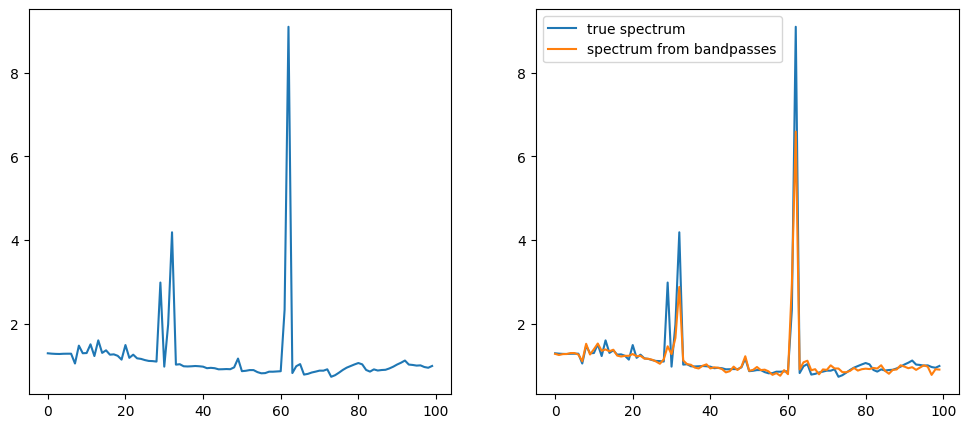

[0.18991028 0.00747291 0.1        0.05      ]


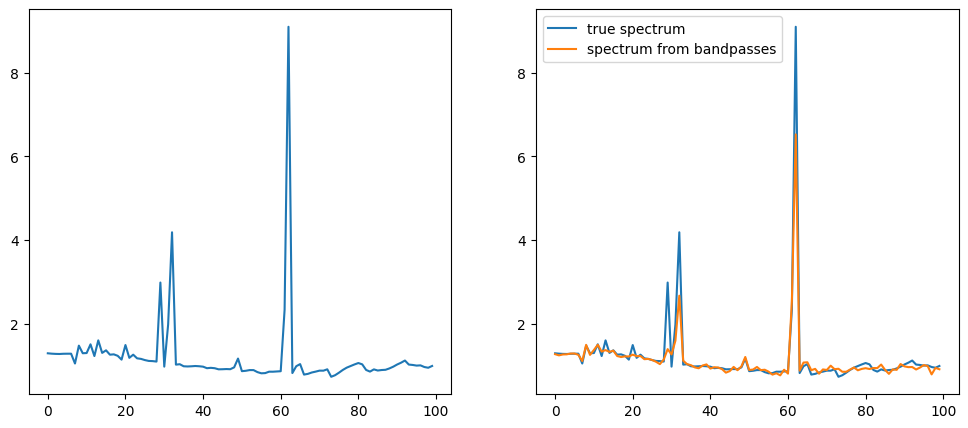

[0.18991028 0.00747291 0.1        0.05      ]


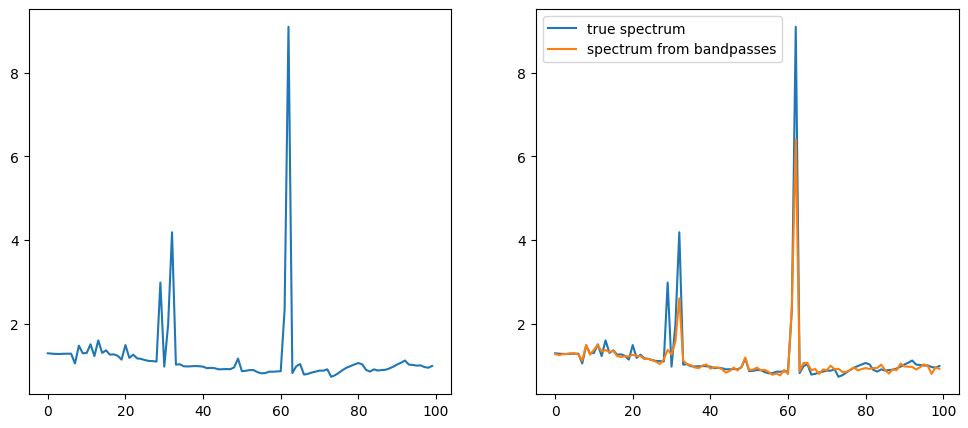

[0.18991028 0.00747291 0.1        0.05      ]


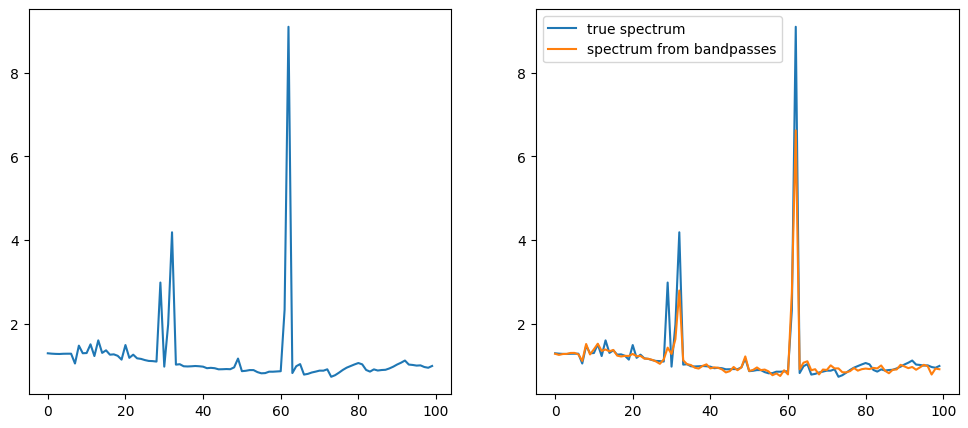

[1.09939757 0.00747291 0.1        0.05      ]


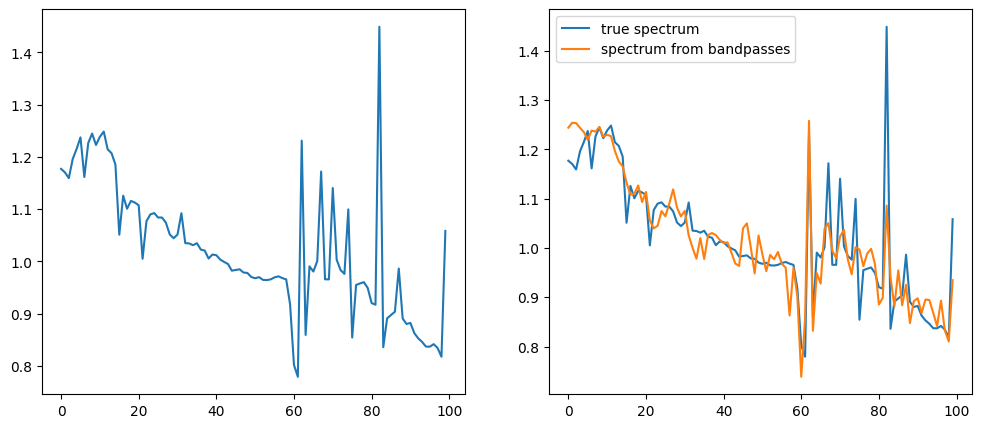

[1.09939757 0.00747291 0.1        0.05      ]


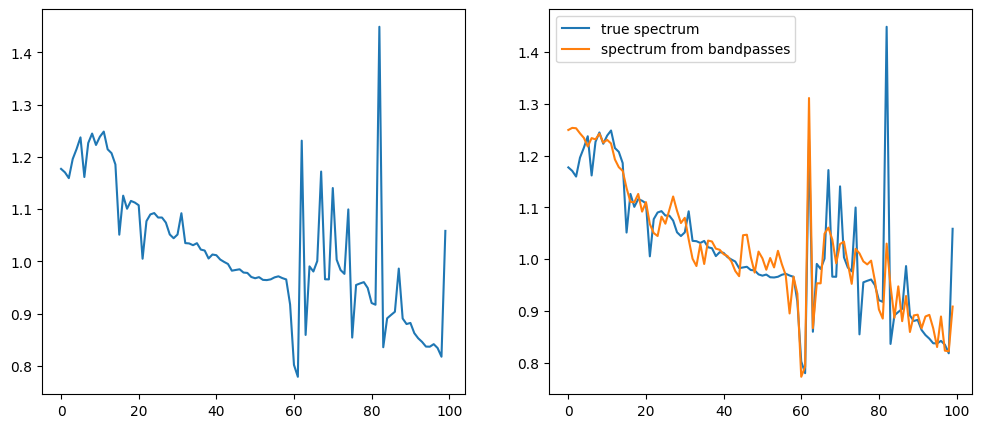

[1.09939757 0.00747291 0.1        0.05      ]


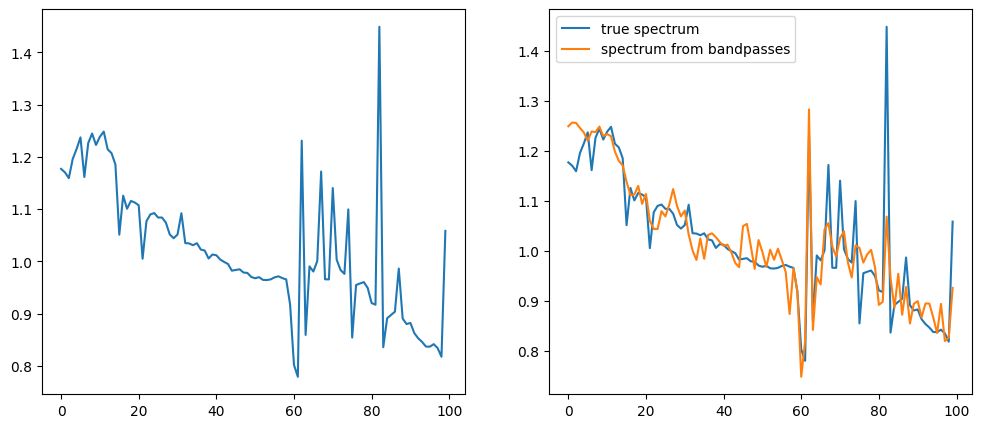

[1.09939757 0.00747291 0.1        0.05      ]


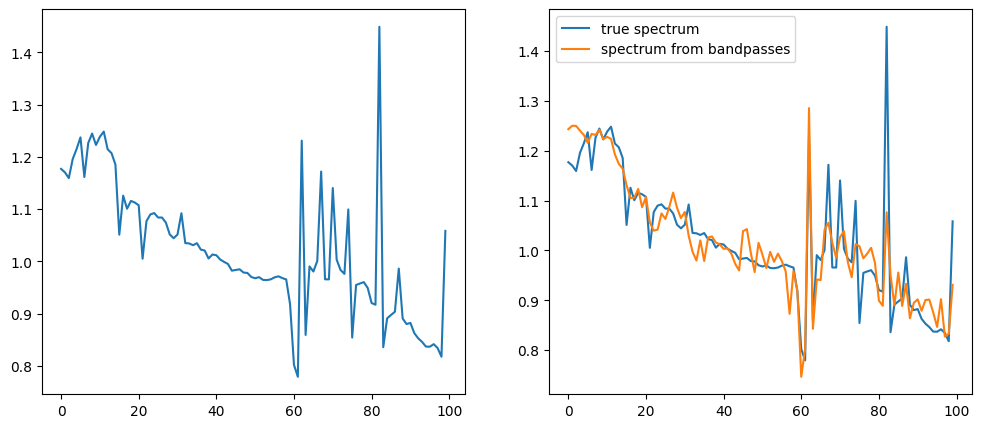

[1.09939757 0.00747291 0.1        0.05      ]


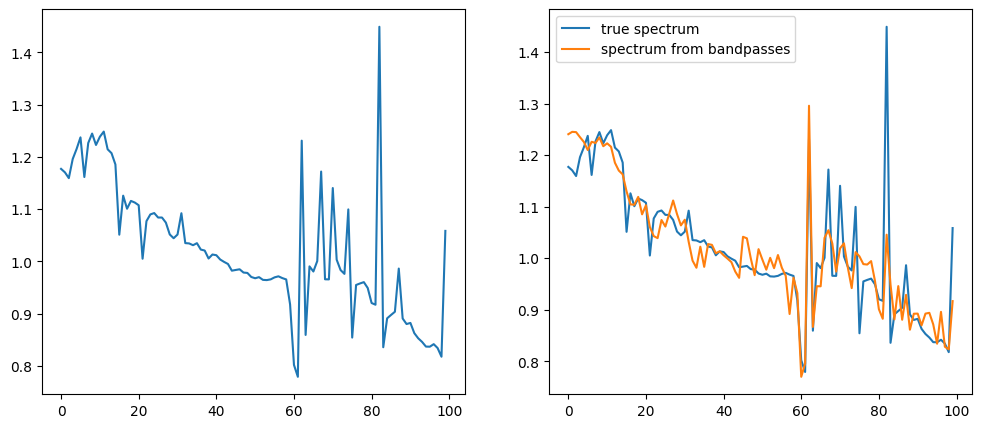

[1.09939757 0.00747291 0.1        0.05      ]


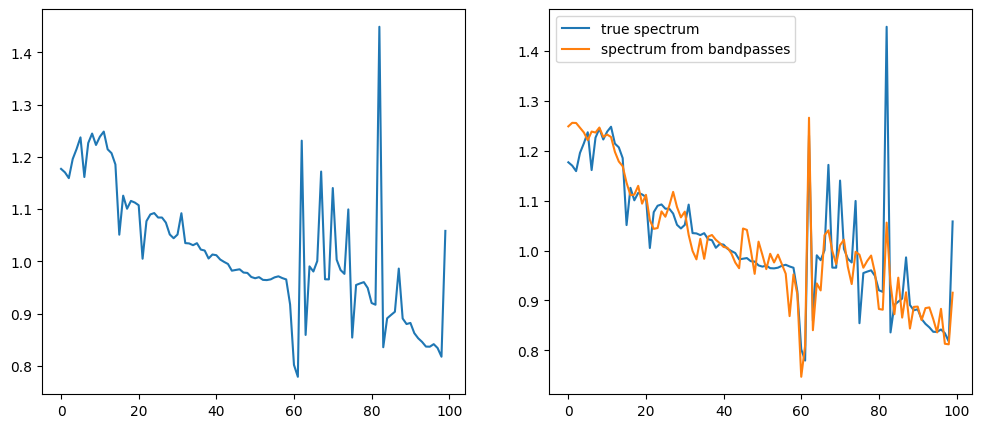

In [32]:


ii=15526
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    print(params[ii])
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()
    

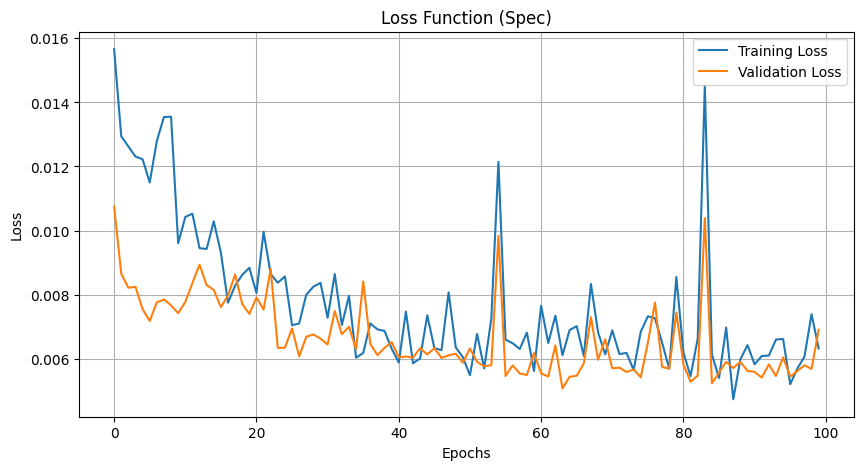

In [33]:
history = hsp.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function (Spec)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
save_path_bp = os.path.join(weight_path, 'epochs/BandPassVAE/')
os.makedirs(save_path_bp, exist_ok=True)


bpvae = BandPassVAE(5,latent_dim, spvae, beta=beta[1])
bpvae.compile(optimizer=keras.optimizers.Adam())

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path_bp, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

bpvae(tf.zeros((1, 5)))


hbp=bpvae.fit((integrals, spectra), epochs=epochs, batch_size=batch_size, validation_split=0.2,
            callbacks=[checkpoint_cb])


Epoch 1/100


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(64, 5))
  warnings.warn(msg)


3743/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 11.7899 - loss: 0.0687 - reconstruction_loss: 0.0652((<tf.Tensor 'data:0' shape=(None, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 100) dtype=float32>),)


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(None, 5))
  warnings.warn(msg)



Epoch 1: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/BandPassVAE/weights_epoch_01.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - kl_loss: 11.7897 - loss: 0.0687 - reconstruction_loss: 0.0651 - val_kl_loss: 11.4956 - val_loss: 0.0778 - val_reconstruction_loss: 0.0744
Epoch 2/100
3735/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 11.8624 - loss: 0.0479 - reconstruction_loss: 0.0443
Epoch 2: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/BandPassVAE/weights_epoch_02.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 11.8626 - loss: 0.0479 - reconstruction_loss: 0.0443 - val_kl_loss: 10.5575 - val_loss: 0.0663 - val_reconstruction_loss: 0.0631
Epoch 3/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 12.4058 - loss: 0.0408 - reconstruction_loss: 0.0371
Epoch 3: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/BandPassVAE/weights_epoch_03.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_loss: 12.4055 - loss: 0.0408 - reconstru

In [35]:
be_tot = np.argmin(hbp.history['loss']) + 1
be_val = np.argmin(hbp.history['val_loss']) + 1

print('Best epochs:', be_tot, be_val)


weight_file = os.path.join(save_path_bp, f'weights_epoch_{be_val:02d}.weights.h5')

print('Loading (best loss): ', weight_file)

#bpvae.load_weights(weight_file)


Best epochs: 31 47
Loading (best loss):  /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/BandPassVAE/weights_epoch_47.weights.h5


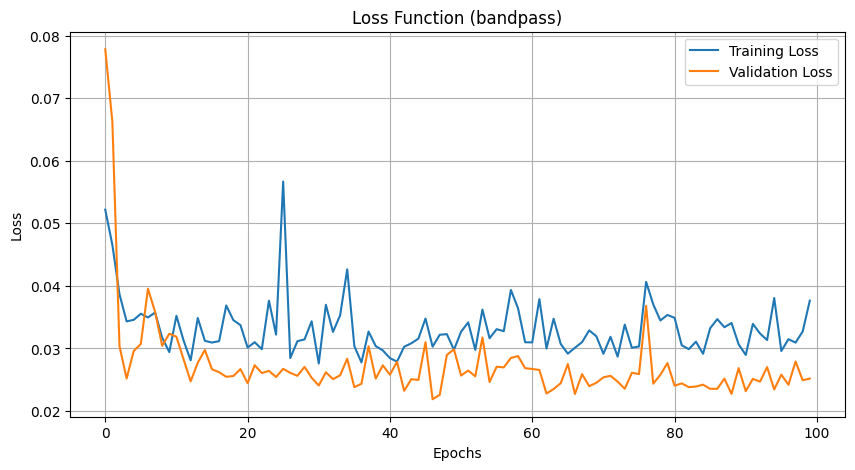

In [36]:
history = hbp.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function (bandpass)')
plt.legend()
plt.grid(True)
plt.show()

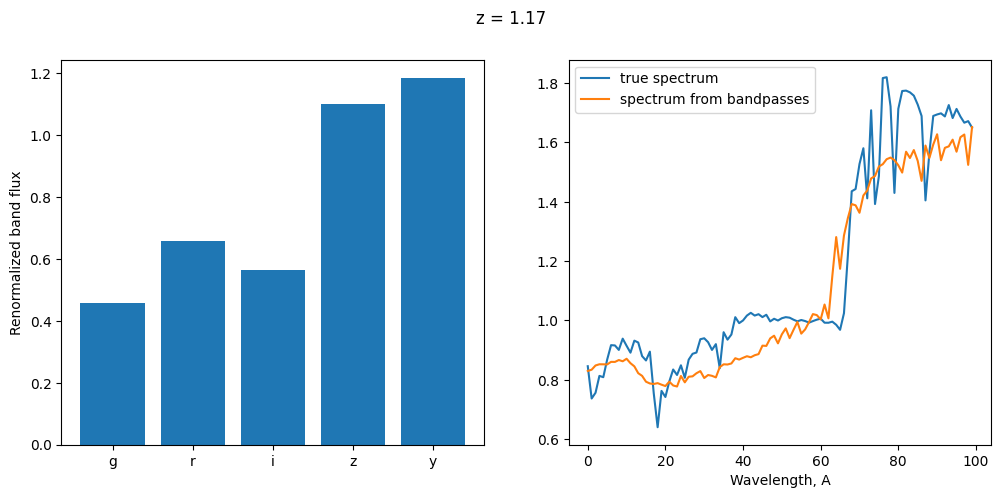

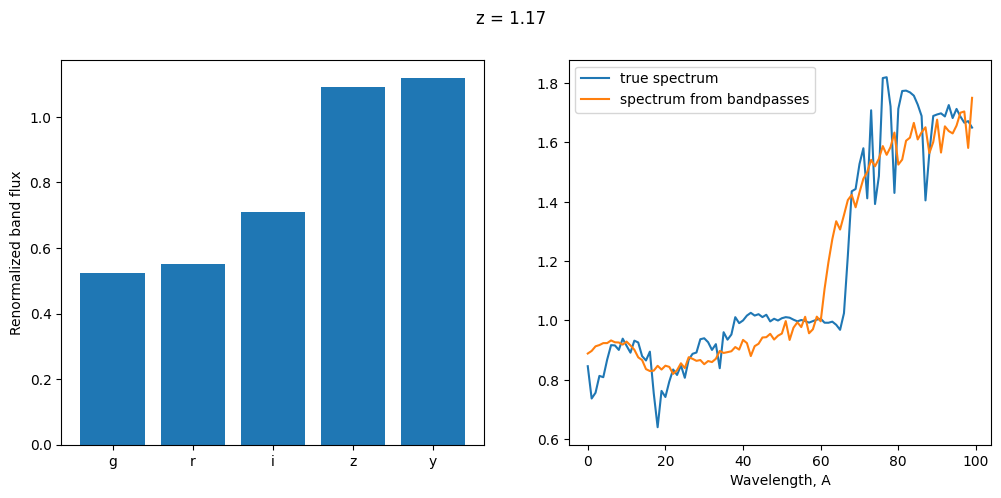

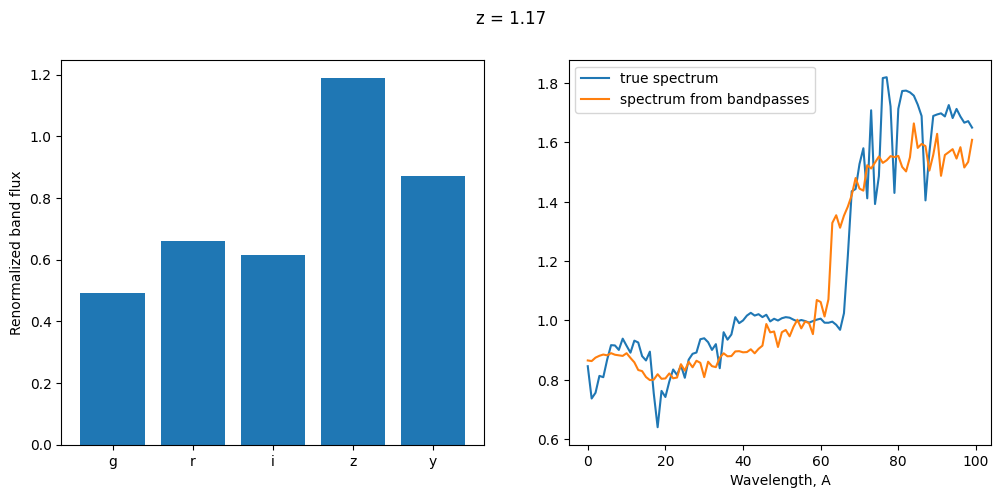

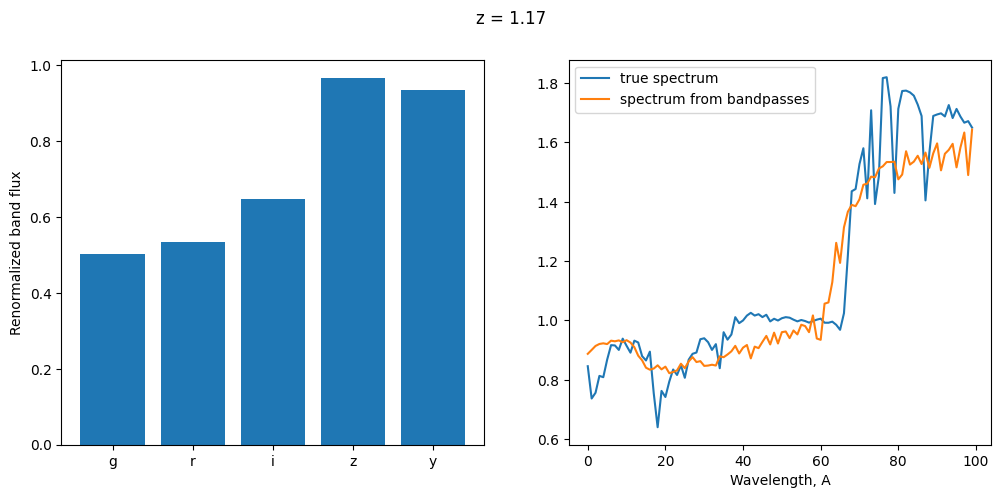

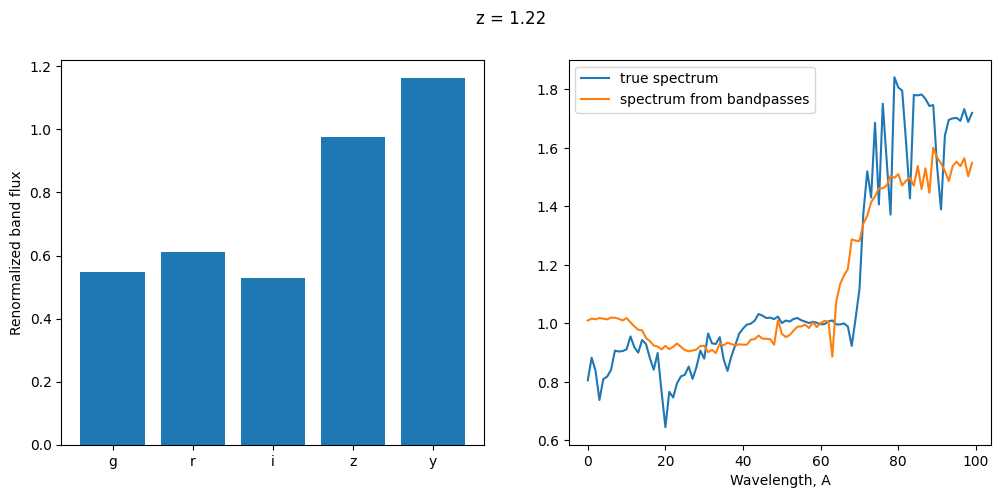

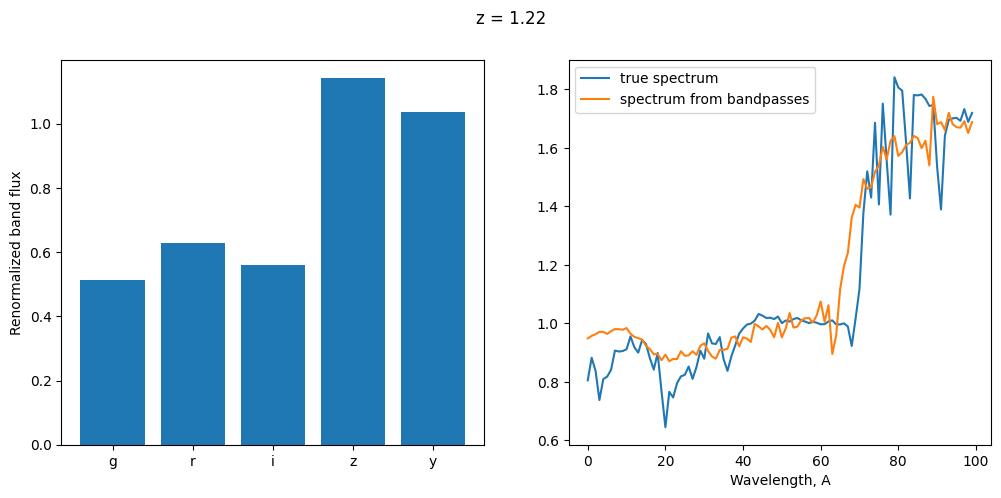

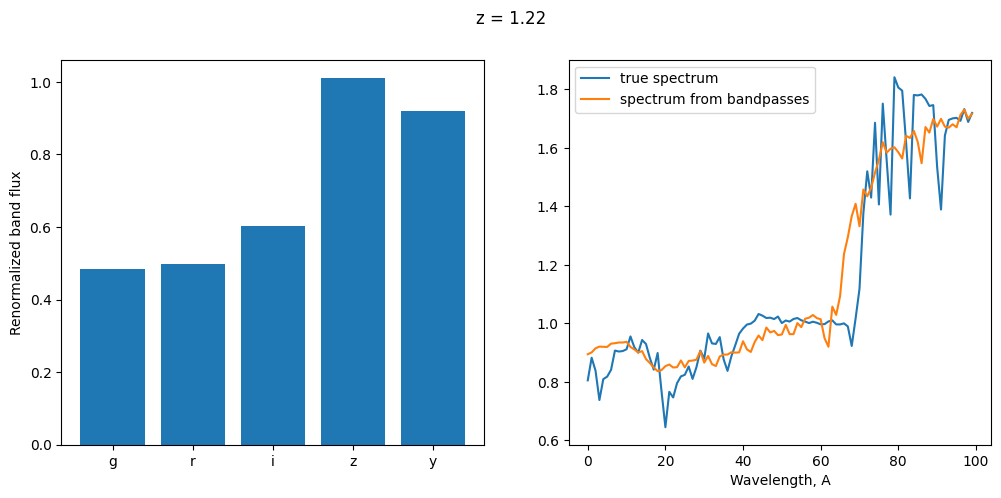

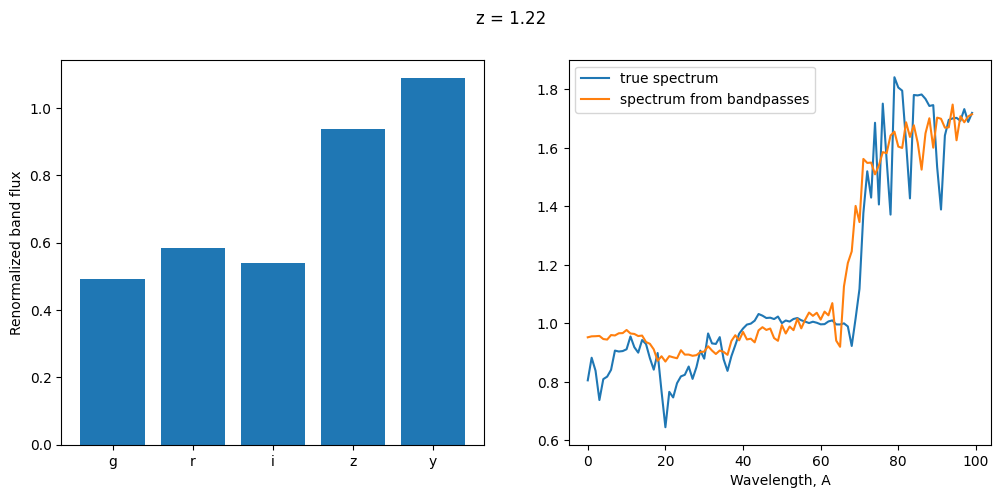

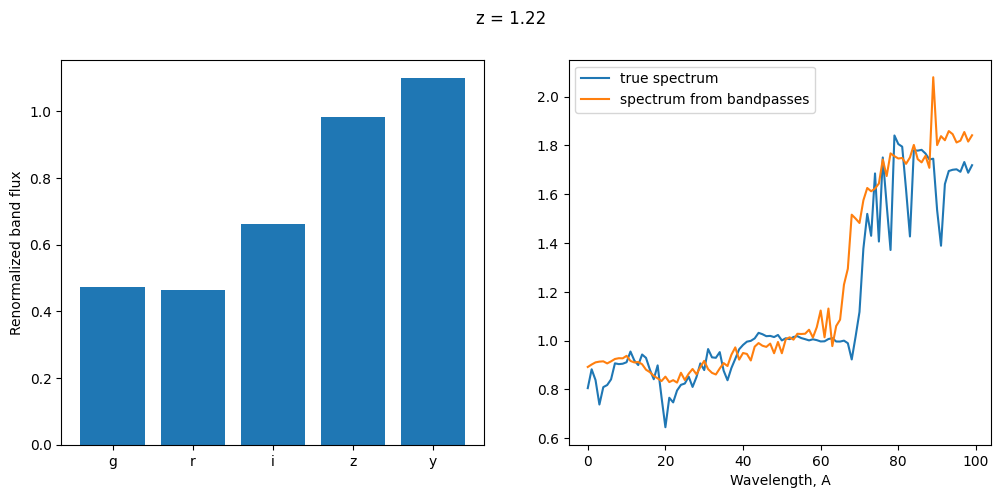

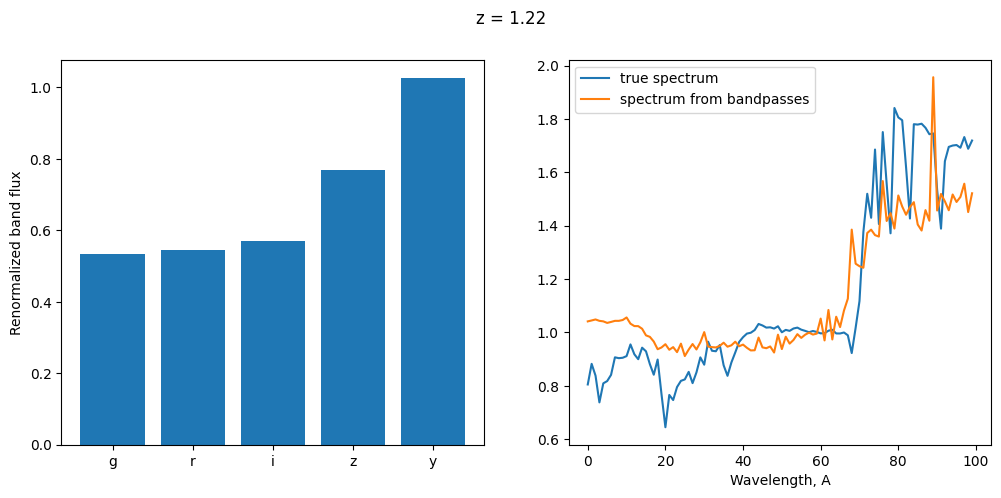

In [37]:

ii=13126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(['g', 'r', 'i', 'z', 'y'],integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()



In [38]:
save_path_param = os.path.join(weight_path, 'epochs/ParamVAE/')
os.makedirs(save_path_param, exist_ok=True)

parvae = ParamVAE(100, latent_dim, 
                  spvae, beta=beta[2],
                  n_param=n_param)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path_param, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

parvae(tf.zeros((1, 100)))


parvae.compile(optimizer=keras.optimizers.Adam())
hp=parvae.fit((spectra, params), epochs=epochs, batch_size=batch_size, validation_split=0.2,
             callbacks=[checkpoint_cb])

Epoch 1/100
3735/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 26.6678 - loss: 0.0039 - reconstruction_loss: 0.0031
Epoch 1: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/ParamVAE/weights_epoch_01.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - kl_loss: 26.6682 - loss: 0.0039 - reconstruction_loss: 0.0031 - val_kl_loss: 25.2268 - val_loss: 0.0297 - val_reconstruction_loss: 0.0289
Epoch 2/100
3704/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 26.6685 - loss: 0.0033 - reconstruction_loss: 0.0025
Epoch 2: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/ParamVAE/weights_epoch_02.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 26.6682 - loss: 0.0033 - reconstruction_loss: 0.0025 - val_kl_loss: 25.2268 - val_loss: 0.0306 - val_reconstruction_loss: 0.0298
Epoch 3/100
3741/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 26.6681 - loss: 0.0032 - reconstruction_loss: 0.0024
Epoch 3: saving model to /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/ParamVAE/weights

In [39]:
be_tot = np.argmin(hp.history['loss']) + 1
be_val = np.argmin(hp.history['val_loss']) + 1

print('Best epochs:', be_tot, be_val)


be_tot = 99

weight_file = os.path.join(save_path_param, f'weights_epoch_{be_tot:02d}.weights.h5')

print('Loading (best loss): ', weight_file)

#parvae.load_weights(weight_file)


Best epochs: 25 48
Loading (best loss):  /data/kirg/MMVAE/bpz_tmpl_1.1/epochs/ParamVAE/weights_epoch_99.weights.h5


In [40]:
parvaeapply = ParamVAEapply(5,latent_dim, bpvae, parvae, beta=beta[2])

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(300000, 5))
  warnings.warn(msg)


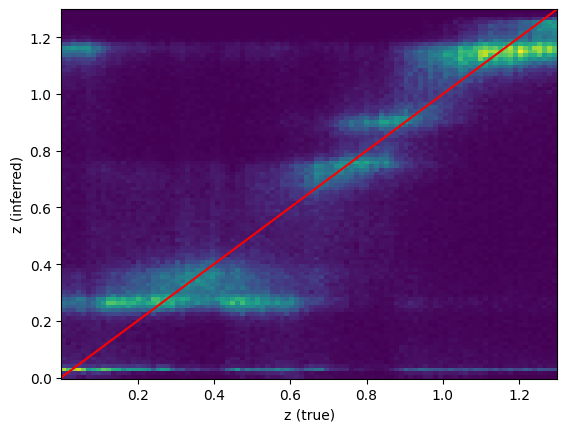

In [41]:
s = parvaeapply(integrals)

plt.hist2d(params[:, 0], s[:, 0], bins=100)
plt.xlabel('z (true)')
plt.ylabel('z (inferred)')
plt.plot([0,1.5], [0,1.5], color='red')
plt.show()

/home/kirg/MMVAE/vae_mpoe/validate_HSC.py:25: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(174304, 5))
  warnings.warn(msg)


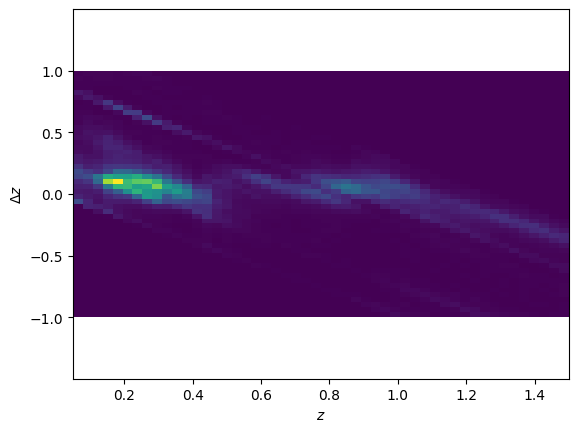

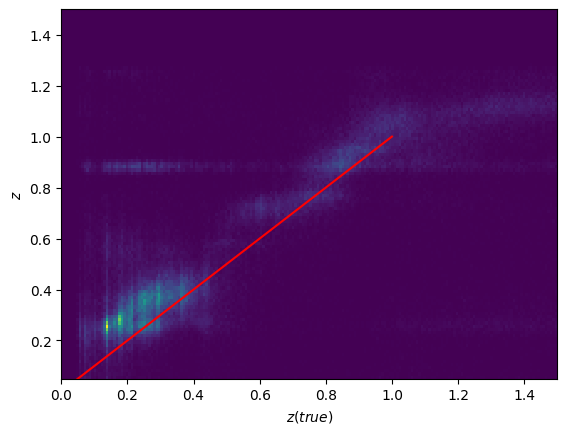

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(160762, 5))
  warnings.warn(msg)


tf.Tensor([0.8202278  0.02229382 0.00935876 0.01973653], shape=(4,), dtype=float32) 0.822681493570212


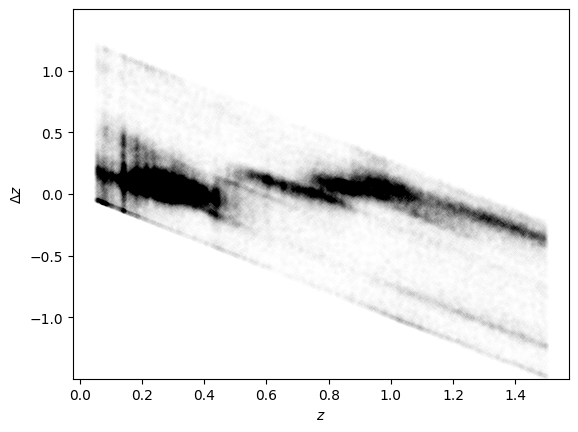

[0.82268149 0.78530661 0.78958418 ... 0.0872988  0.0873343  0.15478596]


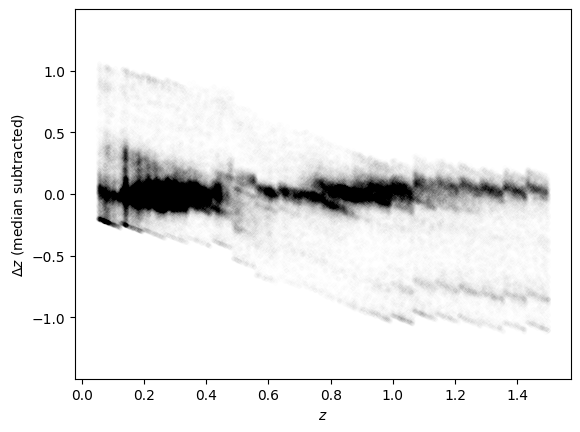

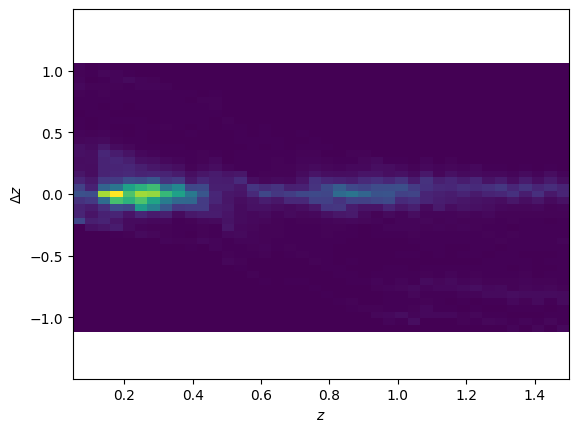

0.08437658764971312 -0.01718007 0.13354823
0.1609518218259867 -0.008089289 0.055794694
0.23224574072286575 -0.0077746436 0.07008473
0.3005030542082366 -0.0037538111 0.07287732
0.3729144105629544 -0.0037336051 0.06712623
0.4446966716478358 -0.0031167716 0.10669265
0.5197335356044075 0.0021260679 0.15964773
0.5938853787654966 0.014262259 0.047736466
0.6671444408673443 0.005194813 0.048744887
0.7426516752135683 0.0009486675 0.07552972
0.8132416903009981 0.0038912594 0.080282494
0.8829454610983705 0.003087014 0.066670045
0.9562775539020024 0.0074515045 0.07137206
1.0278397035317333 0.018684685 0.074778795
1.098601086032606 0.040562123 0.087984316
1.173570685105528 0.038502216 0.08849031
1.2449487916804096 0.040542483 0.08535812
1.3181538923260399 0.029022574 0.05655781
1.3911223519634741 0.032402933 0.06115947
1.4637685905658395 0.04025638 0.062371574


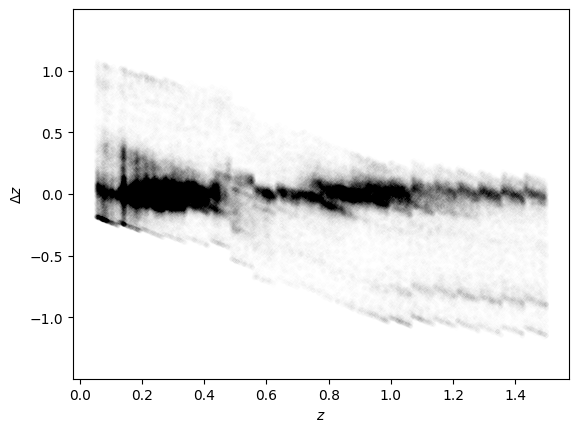

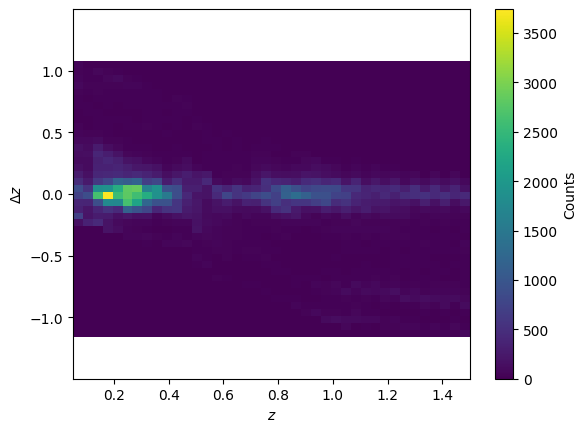

NameError: name 'stop' is not defined

In [42]:


filename = ['test1.png',
           'test2.png',
           'test3.png',
           'test4.png',
           'test5.png',
           'test6.png',
           'test7.png']

validate_HSC(parvaeapply, filename, fig_path='/home/kirg/fig_test',
             show = [True, True, True, True, True, True, True],
             hsc_table='DESI_DR1_HSCSSP_clean_v2.fits', 
             z_min=0.05, z_max=1.50,
             hist2d_zz_kwargs=dict(bins=200, range=[[0, 1.5], [-0.5, 1.5+0.5]]))
stop()

In [ ]:
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

In [ ]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

In [ ]:
idx_sel = np.where(params[:,0] == params[200000, 0])[0]

for i in range(0, 5):
    plt.hist(integrals[idx_sel][:,i])

plt.xscale('log')
plt.show()

In [ ]:
'''
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
'''

In [ ]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

print(t_hsc.colnames)

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]

print(plx[:10])

plt.hist2d(plx, ply, range=[[0, 1], [-1, 1]], bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
filename = f"plot_dz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], range=[[0, 1], [-1, 1]], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
filename = f"plot_zz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

t_hsc['z_photo'] = s[:, 0]



In [ ]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0) &
                (t_hsc_['g_kronflux_mag'] > 0) &
                (t_hsc_['r_kronflux_mag'] > 0) &
                (t_hsc_['i_kronflux_mag'] > 0) &
                (t_hsc_['z_kronflux_mag'] > 0) &
                (t_hsc_['y_kronflux_mag'] > 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeapply(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p
print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
t_hsc['z_photo'] = s[:, 0]

In [ ]:
plx = np.array(p[:])
ply = np.array(res[:])
print(plx)
# Set number of bins
N = 20  # You can change this to whatever number of bins you want

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract median ply in each bin
corrected_ply = ply
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        median_val = np.median(ply[bin_mask])
        corrected_ply[bin_mask] -= median_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$ (median subtracted)')
plt.show()

plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


from astropy.stats import sigma_clip


N = 20

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        clipped = sigma_clip(ply[bin_mask], sigma=2.5, maxiters=20)
        mean_val = np.median(clipped.data[~clipped.mask])
        print(np.mean(plx[bin_mask]), mean_val)
        corrected_ply[bin_mask] -= mean_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

# 2D histogram
plt.hist2d(plx, corrected_ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.colorbar(label='Counts')
plt.show()


In [ ]:
#r = t_hsc[t_hsc['targetid'] == 39627749068903312][0]
r = t_hsc[t_hsc['targetid'] == 39627755112897953][0]

ii = 50500

print(r['ra'], r['dec'])

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
mags_err = np.array([r['g_kronflux_magerr'], r['r_kronflux_magerr'], r['i_kronflux_magerr'], r['z_kronflux_magerr'], r['y_kronflux_magerr']])

print(mags, mags_err)

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
#plt.legend()
plt.show()

p_ls = parvaeapply.apply(np.reshape(bandfl, (1,5)))


p = parvaeapply(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvaeapply(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.axvline(r['z'])

plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
target_id = 39627827598855683
nsmpl_lat = 1000

# Extract data for target
r = t_hsc[t_hsc['targetid'] == target_id][0]
print("RA, Dec:", r['ra'], r['dec'])

# Extract magnitudes and errors
mag_keys = ['g_kronflux_mag', 'r_kronflux_mag', 'i_kronflux_mag', 'z_kronflux_mag', 'y_kronflux_mag']
magerr_keys = [k + 'err' for k in mag_keys]

mags = np.array([r[k] for k in mag_keys])
mags_err = np.array([r[k] for k in magerr_keys])

print("Input Magnitudes:", mags)
print("Magnitude Errors:", mags_err)

# Sample different magnitudes
mag_samples = np.random.normal(loc=mags, scale=mags_err, size=(nsmpl_lat, len(mags)))

# Convert magnitudes to normalized fluxes
bandfl_samples = 10**(-0.4 * mag_samples)
bandfl_samples /= np.max(bandfl_samples, axis=1)[:, None]  # normalize per sample

# Apply parvae to each sample
param_evals = []
for i in range(nsmpl_lat):
    band_input = np.reshape(bandfl_samples[i], (1, -1))
    p = parvaeapply(band_input)
    param_evals.append(p[0].numpy())

param_evals = np.array(param_evals)

# Plot: 1D Histogram of First Parameter (e.g., redshift)
plt.hist(param_evals[:, 0], bins=30)
plt.axvline(r['z'], color='r', linestyle='--', label='Catalog z')
plt.xlabel("redshift")
plt.ylabel("Count")
plt.title("Distribution of redshift")
plt.legend()
plt.show()

# Plot: 2D Scatter of First Two Parameters
plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("Scatter of Inferred Parameters")
plt.show()

# Plot: 2D Histogram
plt.hist2d(param_evals[:, 0], param_evals[:, 1], bins=30)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("2D Histogram of Inferred Parameters")
plt.colorbar()
plt.show()

In [ ]:
mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.022**2)[0]

p_v = params[idx]

plt.plot(param_evals[:, 0], param_evals[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(r['z'])
#plt.axhline(r['ssp_age']/1e4)

plt.show()

In [ ]:
ii = 5700

bandfl = integrals[ii]

idx_same_smpl = np.where(params == params[ii])[0]
print(idx_same_smpl)


nsmpl = 10
p_est = []
for idx_sm_ in idx_same_smpl:
    for i in range(nsmpl):
        p_estls = parvaeapply(np.reshape(integrals[idx_sm_], (1,5)))
        p_est.append(p_estls[0].numpy())

p_est = np.array(p_est)

p0 = params[ii]

print(p0)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')

s = parvaeuse(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
plt.show()




rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.006**2)[0]


p_v = params[idx]

plt.plot(p_est[:, 0], p_est[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(p0[0])
plt.axhline(p0[1])

plt.show()

